## MNIST 데이터 준비

In [108]:
from pathlib import Path    # pathlib는 파일위치 찾기, 파일 입출력에 사용하는 모듈. 과거 os모듈
import requests             # 간편한 HTTP 요청처리를 위해 사용하는 모듈

# 1. 폴더를 만들고, MNIST 데이터 다운로드 하기
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"  # os.path.join과 같은 느낌

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [109]:
import pickle   # 파일 load하는데 많이 사용되는 모듈
import gzip     # 압축된 파일의 내용을 바로 읽을 수 있는 모듈

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

이미지는 28 x 28 형태 이고, 784 (=28x28) 크기를 가진 하나의 행
=> 이를 확인하기 위해 2d로 전환

(50000, 784)


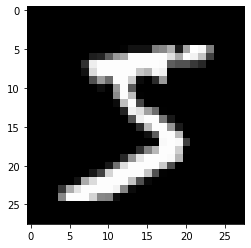

In [110]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

* torch.tensor 를 사용하므로, 우리는 데이터를 변환

In [111]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## torch.nn을 사용하지 않고 신경망 구현해보기

In [112]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)  #Xavier initialisation 기법을 이용하여 가중치를 초기화(1/sqrt(n)을 곱해주는 것을 통해서 초기화)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

## Xavier initialisation

참고: https://gomguard.tistory.com/184

* 딥러닝 학습에 있어 초기 가중치 설정은 매우 중요한 역할
* 가중치를 잘못 설정할 경우 기울기 소실 문제나 표현력의 한계를 갖는 등 여러 문제를 야기
* 딥러닝의 학습의 문제가 non-convex 이기 때문에 초기값을 잘못 설정할 경우 local minimum에 수렴할 가능성이 커지게 됨
* 가중치를 초기화 할 때 가장 중요한 것은 출력값들이 표준 정규 분포 형태를 갖게 하는 것 
* 출력값들이 표준 정규 분포 형태를 갖게 되어야 안정적으로 학습이 가능

### ** Xavier initialisation **
    - 이전 노드와 다음 노드의 개수에 의존하는 방법
    - 표준 정규 분포를 입력 개수의 표준 편차로 나누어 초기화
    
$ W∼N(0,Var(W)) $


$  standard\ deviation\ \sigma =\sqrt{2\over n_{in}+n_{out}} $

You should consider upgrading via the '/Users/mac/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


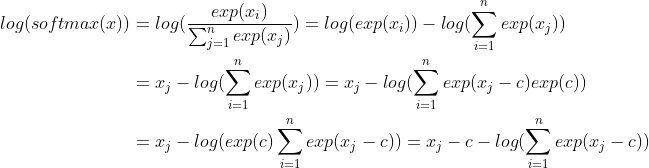

In [85]:
!pip install IPython 
from IPython.display import Image
Image("/Users/mac/Dropbox/Y_AI_LAB/파이토치스터디/logsoftmax.png")

In [113]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)  

def model(xb):
    return log_softmax(xb @ weights + bias)  # @: dot product

In [114]:
bs = 64  # 배치 사이즈

xb = x_train[0:bs]  # x로부터 미니배치(mini-batch) 추출
preds = model(xb)  # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.4747, -1.8152, -1.9867, -2.7386, -2.6188, -2.1983, -2.2775, -2.2328,
        -2.4032, -2.7012], grad_fn=<SelectBackward>) torch.Size([64, 10])


* 손실함수(loss function)로 사용하기 위한 음의 로그 우도(negative log-likelihood)를 구현

In [115]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [116]:
yb = y_train[0:bs]
print(yb.shape)   #64장의 이미지 각각의 class가 적혀있음
print(loss_func(preds, yb))

torch.Size([64])
tensor(2.3032, grad_fn=<NegBackward>)


* accuracy function

In [117]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)   #argmax: 각 예측에 대해 가장 큰 값을 가진 인덱스가 목표 값과 일치함을 판단
    # dim=1 -> shape : (64, 10)-> (64)
    return (preds == yb).float().mean()

In [118]:
print(accuracy(preds, yb))

tensor(0.0625)


## loop를 통한 훈련

* 데이터 가져오기 -> forward-> loss 계산-> backward-> 가중치 갱신

In [96]:
lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에포크(epoch) 수

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()   #다시 0으로 설정-> 다음 loop를 돌리기 위해

In [97]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0657, grad_fn=<NegBackward>) tensor(1.)


## torch.nn.functional

* 간결하고 유연한 코드 (활성화, 손실 함수를 torch.nn.functional 의 함수로 대체)

* 음의 로그 우도 손실과 로그 소프트맥스 (log softmax) 활성화 함수를 사용하는 경우 => Pytorch는 이 둘을 결합하는 단일 함수인 F.cross_entropy 를 제공

In [98]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [99]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0657, grad_fn=<NllLossBackward>) tensor(1.)


=> 손실과 정확도과 이전과 동일

## Refactor using nn.Module

* 더 명확하고 간결한 훈련 루프를 위해 nn.Module 및 nn.Parameter 를 사용

In [100]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
         # nn.Parameter(텐서) : 이 텐서를 parameter로 이용할 것을 명명한다. grad를 알아서 해준다.
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [101]:
model = Mnist_Logistic()

In [102]:
print(loss_func(model(xb), yb))  #함수 호출 가능

tensor(2.2239, grad_fn=<NllLossBackward>)


In [105]:
# with torch.no_grad():
#    weights -= weights.grad * lr
#   bias -= bias.grad * lr
#    weights.grad.zero_()
#    bias.grad.zero_()
# 이전에는 수동으로 0으로 초기화

with torch.no_grad():   #nn.Module에 의해 정의된 model.parameters() 및 model.zero_grad()를 통해 간결하게 해결 가능
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

In [104]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()   #위의 과정을 한번에 함수로 저장

In [106]:
print(loss_func(model(xb), yb))

tensor(0.0828, grad_fn=<NllLossBackward>)


## Refactor using nn.Linear

* self.weights 및 self.bias 를 수동으로 정의 및 초기화하고, xb  @ self.weights + self.bias 를 계산하는 대신
=> nn.Linear로 코드 구현

In [51]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [52]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3510, grad_fn=<NllLossBackward>)


In [53]:
fit()   #위에서 정의한 함수 그대로 사용

print(loss_func(model(xb), yb))

tensor(0.0833, grad_fn=<NllLossBackward>)


## Refactor using optim
위에서 했던


with torch.no_grad():


    for p in model.parameters(): p -= p.grad * lr
    
    model.zero_grad()
    
    
과정을 optim를 이용해 쉽게 구현 가능

opt.step()

opt.zero_grad()

* optim.zero_grad() 는 기울기를 0으로 재설정

In [57]:
from torch import optim

In [58]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.1875, grad_fn=<NllLossBackward>)
tensor(0.0814, grad_fn=<NllLossBackward>)


## Refactor using Dataset
* TensorDataset 은 텐서를 감싸는(wrapping) Dataset 
* 길이와 인덱싱 방식을 정의함으로써 텐서의 첫 번째 차원을 따라 반복, 인덱싱 및 슬라이스(slice)하는 방법도 제공

In [59]:
from torch.utils.data import TensorDataset

In [60]:
train_ds = TensorDataset(x_train, y_train)

In [107]:
""" 위에서는 이렇게 했었다. 
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
""" 

xb,yb = train_ds[i*bs : i*bs+bs]  #한번에 가능

In [63]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0827, grad_fn=<NllLossBackward>)


## Refactor using DataLoader

* 배치 관리 쉽게 가능 (train_ds[i* bs : i* bs+bs] 를 사용하는 대신, DataLoader 는 매 미니배치를 자동적으로 제공)

In [64]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [66]:
""" 위에서는 이렇게 했었다. 
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
"""

for xb,yb in train_dl:
    pred = model(xb)

In [67]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0834, grad_fn=<NllLossBackward>)


## Validation

* 과적합 (overfitting)을 피하기 위해 train set을 shuffling(섞거나, 랜덤하게 뽑기) 이용 하지만 검증 손실 (validation loss)은 그런 작업이 필요 없음
* 검증 데이터셋에 대해서는 역전파가 필요하지 않기 때문에 메모리 사용이 덜함 -> 따라서 배치 사이즈를 train 보다 2배로 늘려서 사용 => 더욱 빠르게 손실 계산 가능

In [68]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [69]:
model, opt = get_model()

#훈련 전에 항상 model.train() 을 호출하고
#추론(inference) 전에 model.eval() 을 호출
# nn.BatchNorm2d 및 nn.Dropout 과 같은 레이어에서 훈련, 추론 에 대한 적절한 동작이 일어나게 하기 위함
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2992)
1 tensor(0.3117)


## 함수로 만들기

1) loss_batch : one batch에 대해서 loss를 구해주는 함수

2) fit : loss_batch함수를 이용해서, 모델 전체를 train, validation 해주는 함수

3) get_data : 학습 및 검증 데이터셋에 대한 dataloader 를 출력

In [70]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [71]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [73]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

이제 dataloader를 가져오고 모델을 훈련하는 전체 프로세스를 3 줄의 코드로 실행 가능

In [74]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.29886603088378905
1 0.3126581490397453


## nn.Linear 대신하여 CNN 사용하기

In [75]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()     #super()를 사용해서 기반 클래스의 __init__ 메서드를 호출
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)   # 평균 풀링(average pooling)을 수행
        return xb.view(-1, xb.size(1))

lr = 0.1

In [76]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.40941188502311704
1 0.2605185572385788


## nn.Sequential

* Sequential 객체는 그 안에 포함된 각 모듈을 순차적으로 실행
- 이를 활용하려면 주어진 함수에서 사용자정의 레이어(custom layer) 를 쉽게 정의해야함

In [77]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [78]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33244466631412506
1 0.24224171254634858


## Wrapping DataLoader

* 모든 2d single channel image라면 input을 무조건 받을 수 있는, model을 구현
* 위에서는 preprocess라는 함수를 정의하고, nn.Sequential(Lambda(preprocess), … ; 처럼 사용
- 아에 처음부터 train_dl, valid_dl을 view처리를 한 상태에서 model에 집어넣어봄 (warpping)


In [79]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [80]:
# nn.AvgPool2d 를 nn.AdaptiveAvgPool2d 로 대체하여 우리가 가진 입력 텐서가 아니라 원하는 출력 텐서의 크기를 정의


model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [82]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.8433016169548034
1 0.49604337162971496
